# Models


### Import libraries

In [995]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.decomposition import PCA
from tensorflow.keras.applications import Xception
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, concatenate




#turn off warnings
import warnings
warnings.filterwarnings('ignore')



### Read CSV file containing YouTube video data

In [996]:
# TODO: Make this part of another notebook or .py file that is used to process and split the data

# Read CSV file
yt_data = pd.read_csv('../data/youtube_video_data.csv')

# Drop the CSV file's numeric row count/index column
yt_data = yt_data.drop('Unnamed: 0', axis=1)

# Convert 2 date columns into datetime objects
yt_data['video_published_at'] = pd.to_datetime(yt_data['video_published_at'])
yt_data['channel_published_at'] = pd.to_datetime(yt_data['channel_published_at'])

# Output the dataframe
yt_data

,video_id,title,description,video_published_at,hours_published_video,num_tags,channel,channel_id,thumbnail_url,thumbnail_width,...,views,likes,favorites,comments,channel_description,channel_published_at,days_published_channel,channel_views,channel_videos,channel_subscribers
0,x_t53a5Ons0,Metallica: If Darkness Had a Son (Official Mus...,Metallica's official music video for “If Darkn...,2023-03-01 15:00:43+00:00,14.864821,8,Metallica,UCbulh9WdLtEXiooRcYK7SWw,https://i.ytimg.com/vi/x_t53a5Ons0/default.jpg,120,...,1190584,104266.0,0,11027.0,The Official Metallica YouTube Channel,2007-01-30 00:12:55+00:00,5875.236114,5029599596,1819,9460000
1,WM8bTdBs-cw,Metallica: One (Official Music Video),"Metallica's official music video for “One,” fr...",2009-10-27 01:53:30+00:00,116979.985099,7,Metallica,UCbulh9WdLtEXiooRcYK7SWw,https://i.ytimg.com/vi/WM8bTdBs-cw/default.jpg,120,...,279959343,1691453.0,0,76073.0,The Official Metallica YouTube Channel,2007-01-30 00:12:55+00:00,5875.236114,5029599596,1819,9460000
2,qz8yjPTMJf4,Metallica: Screaming Suicide (Official Lyric V...,"Metallica’s official lyric video, “Screaming S...",2023-01-25 14:01:00+00:00,855.860099,8,Metallica,UCbulh9WdLtEXiooRcYK7SWw,https://i.ytimg.com/vi/qz8yjPTMJf4/default.jpg,120,...,278112,12501.0,0,876.0,The Official Metallica YouTube Channel,2007-01-30 00:12:55+00:00,5875.236114,5029599596,1819,9460000
3,_u-7rWKnVVo,Metallica: Lux Æterna (Official Music Video),Metallica's official music video for “Lux Æter...,2022-11-28 15:00:20+00:00,2246.871210,8,Metallica,UCbulh9WdLtEXiooRcYK7SWw,https://i.ytimg.com/vi/_u-7rWKnVVo/default.jpg,120,...,15976078,483175.0,0,46518.0,The Official Metallica YouTube Channel,2007-01-30 00:12:55+00:00,5875.236114,5029599596,1819,9460000
4,CD-E-LDc384,Metallica: Enter Sandman (Official Music Video),Metallica's official music video for “Enter Sa...,2012-03-19 20:34:06+00:00,95985.308432,7,Metallica,UCbulh9WdLtEXiooRcYK7SWw,https://i.ytimg.com/vi/CD-E-LDc384/default.jpg,120,...,578225232,2857927.0,0,81851.0,The Official Metallica YouTube Channel,2007-01-30 00:12:55+00:00,5875.236114,5029599596,1819,9460000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,UKqkb4cEy-E,Miquella and Malenia: The Full Story | Elden R...,Of all the twins in Elden Ring (which there is...,2022-12-21 15:05:01+00:00,1694.793154,5,V-Limit,UCAXzwpv-8zX3uI95W7YfGYA,https://i.ytimg.com/vi/UKqkb4cEy-E/default.jpg,120,...,207776,8620.0,0,462.0,Explaining lore and solving mysteries in gamin...,2022-03-16 02:18:28+00:00,351.148926,4894758,19,33900
1270,_Pd5weoBjcE,Can I Beat Elden Ring While Getting Hit By Eve...,Thanks to Keeps for sponsoring - Head to https...,2022-11-05 09:57:21+00:00,2803.920932,0,Bushy,UCF5RrlbsxJjAVLWgOCoNHMg,https://i.ytimg.com/vi/_Pd5weoBjcE/default.jpg,120,...,1963328,46974.0,0,2370.0,NaN,2022-01-13 23:41:15+00:00,412.258104,33914550,39,241000
1271,hX7xcxpxHhU,Can I Beat Elden Ring by 1 Shotting the Bosses?,Enjoy!\n\n------------------------------------...,2022-05-16 14:00:18+00:00,6951.871765,1,Bushy,UCF5RrlbsxJjAVLWgOCoNHMg,https://i.ytimg.com/vi/hX7xcxpxHhU/default.jpg,120,...,5840506,124835.0,0,3366.0,NaN,2022-01-13 23:41:15+00:00,412.258104,33914550,39,241000
1272,m4YZcEc1qgI,Elden Ring Lore | Morgott: His Story,The Lore of Morgott in Elden Ring is a tale fo...,2023-02-10 21:03:57+00:00,464.810932,19,Hawkshaw,UC47GDLUPXADaa69O2AqJQ9A,https://i.ytimg.com/vi/m4YZcEc1qgI/default.jpg,120,...,61256,3828.0,0,338.0,"Welcome to Hawkshaw, a channel for going in de...",2015-10-28 14:32:24+00:00,2681.639250,8515004,28,78700



### Add thumbnail pixel array

In [997]:
IMAGE_PATH = '../data/Youtube Thumbnails/' # replace with your path

In [998]:
def preprocess_data(IMAGE_PATH):
    """ Generate lists of images and video ids
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images  (np.ndarray): Images of shape (N, 120, 90, 3)
    """
    images = []
    video_ids = []

    # create lists of images `images_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        
        # read video ID from path
        video_id = img.split('/')[0]
        video_id = video_id.split('.')[0]
        
        # read image
        img = load_img(
            IMAGE_PATH + img
        )
        
        # transform image to array
        img = img_to_array(img)

        #pre process
        img = img / 255
        
        # append to images
        images.append(img)
        video_ids.append(video_id)

    # stack images and trasnform to array
    images = np.stack(images)
    
    #flatten image pixel array and store in pd df with video ids
    images_flat = images.reshape(images.shape[0],images.shape[1] * images.shape[2] * images.shape[3])
    images_flat = pd.DataFrame(images_flat,columns=[("pixel_"+str(i)) for i in range(images_flat.shape[1])])
    images_ids = pd.DataFrame(video_ids,columns=["id"])
    images_df = pd.concat([images_ids,images_flat],axis=1)
    
    return images_df

In [999]:
images_df = preprocess_data(IMAGE_PATH)

In [1000]:
images_df.head()

,id,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_32390,pixel_32391,pixel_32392,pixel_32393,pixel_32394,pixel_32395,pixel_32396,pixel_32397,pixel_32398,pixel_32399
0,MvuqM_9h6QY,0.000000,0.007843,0.000000,0.000000,0.007843,0.000000,0.000000,0.007843,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,hDk1ne5TCHM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LbuoZYZLipc,0.000000,0.003922,0.019608,0.000000,0.003922,0.019608,0.000000,0.003922,0.019608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,hTqOeMob6uM,0.011765,0.000000,0.000000,0.011765,0.000000,0.000000,0.011765,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,RMxuWWN223o,0.000000,0.000000,0.007843,0.000000,0.000000,0.007843,0.000000,0.000000,0.007843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1001]:
yt_data = yt_data.merge(right = images_df,how = 'left', left_on = 'video_id',right_on='id')

### Add thumbnail image classification

In [1002]:
model_Xception = Xception(weights = 'imagenet')

In [1003]:
def preprocess_data_Xception(IMAGE_PATH):
    """ Generate lists of images and video ids
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images  (np.ndarray): Images of shape (N, 120, 90, 3)
    """
    images = []
    video_ids = []

    # create lists of images `images_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        
        # read video ID from path
        video_id = img.split('/')[0]
        video_id = video_id.split('.')[0]
        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(299, 299)
        )
        
        # transform image to array
        img = img_to_array(img)

        #pre process
        img = tf.keras.applications.xception.preprocess_input(img)
        
        # append to images
        images.append(img)
        video_ids.append(video_id)

    # stack images and trasnform to array
    images = np.stack(images)
    
    return images, video_ids

In [1004]:
images_Xception = preprocess_data_Xception(IMAGE_PATH)

In [1005]:
preds = model_Xception.predict(images_Xception[0])

38/38 [==============================] - 124s 3s/step


In [1006]:
labels = tf.keras.applications.xception.decode_predictions(preds, top=3)
labels_list = []
for indx,i in enumerate(labels):
    labels_list.append([images_Xception[1][indx],i[0][1],i[1][1],i[2][1]])
    

In [1007]:
image_labels = pd.DataFrame(labels_list,columns=["video_id"]+[("label_"+str(i)) for i in range(3)])

In [1008]:
yt_data = yt_data.merge(right = image_labels,how = 'left', left_on = 'video_id',right_on='video_id')

### Describe the dataframe

In [1009]:
print("Shape: ", yt_data.shape, "\n")


Shape:  (1274, 32428) 



### Randomize the indices

In [1010]:
np.random.seed(0)
yt_data = yt_data.reindex(np.random.permutation(yt_data.shape[0]))

yt_data

,video_id,title,description,video_published_at,hours_published_video,num_tags,channel,channel_id,thumbnail_url,thumbnail_width,...,pixel_32393,pixel_32394,pixel_32395,pixel_32396,pixel_32397,pixel_32398,pixel_32399,label_0,label_1,label_2
1179,NFjn0X2BL2Q,La Comadre | EVERYNIGHTNIGHTS PODCAST #184,"👩‍👩‍👧‍👦BECOME A MEMBER FOR EXCLUSIVE CONTENT, ...",2023-02-22 05:28:56+00:00,192.394543,16,everydaydays,UC62DsCYR_xWzxeH8ou1WKlg,https://i.ytimg.com/vi/NFjn0X2BL2Q/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,comic_book,book_jacket,web_site
1120,EN4izhntW1g,Cooking Expensive Steak in a Toaster,follow me on twitter ► https://www.twitter.com...,2023-03-01 06:00:01+00:00,23.876488,8,Ludwig,UCrPseYLGpNygVi34QpGNqpA,https://i.ytimg.com/vi/EN4izhntW1g/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,toaster,soap_dispenser,microwave
427,hX_qyf38X9c,Can I Survive 100 Days in Hardcore Survival Mo...,Welcome back to skyrim! Where today we set out...,2022-11-05 19:21:23+00:00,2794.520376,32,The Spiffing Brit,UCRHXUZ0BxbkU2MYZgsuFgkQ,https://i.ytimg.com/vi/hX_qyf38X9c/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,scoreboard,slot,comic_book
351,Qek_UPifJhs,Don Toliver - Time Heals All [Official Audio],Don Toliver - Time Heals All\n'LOVE SICK' the ...,2023-02-24 05:00:11+00:00,144.873710,28,Don Toliver,UCgT01FILdWB9BsXBXKjpQ7A,https://i.ytimg.com/vi/Qek_UPifJhs/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fire_screen,theater_curtain,home_theater
364,iEPxe5c282E,Real Madrid CF v Al Ain | FIFA Club World Cup ...,FULL MATCH: Rewatch Real Madrid v Al Ain the 2...,2023-02-10 18:52:49+00:00,466.996488,28,FIFA,UCpcTrCXblq78GZrTUTLWeBw,https://i.ytimg.com/vi/iEPxe5c282E/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,torch,balance_beam,horizontal_bar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3PnOS94d6v0,I Surprised My Girlfriend With A Custom House!,"I cant believe I painted our $10,000,000 house...",2021-09-22 21:20:48+00:00,12608.530099,0,ZHC,UClQubH2NeMmGLTLgNdLBwXg,https://i.ytimg.com/vi/3PnOS94d6v0/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,screen,web_site,academic_gown
835,ymGt7I4Yn3k,Russell's Paradox - a simple explanation of a ...,This is a video lecture explaining Russell's P...,2022-09-08 15:18:27+00:00,4190.569265,0,Jeffrey Kaplan,UC_hukbByJP7OZ3Xm2tszacQ,https://i.ytimg.com/vi/ymGt7I4Yn3k/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,web_site,Windsor_tie,comic_book
1216,pl80_nOEgbw,Will Anyone Ever Break LeBron's Scoring Record?,For 65% off with HelloFresh PLUS free shipping...,2023-02-26 23:48:26+00:00,78.069543,29,JxmyHighroller,UC3L9XPe0_FGfRG-CMGtBvFg,https://i.ytimg.com/vi/pl80_nOEgbw/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,web_site,television,home_theater
559,qAtyzHZc7l8,Unluckiest People In The World!,imagine being so unlucky you end up in this vi...,2023-02-24 21:00:10+00:00,128.873988,25,Beast Reacts,UCUaT_39o1x6qWjz7K2pWcgw,https://i.ytimg.com/vi/qAtyzHZc7l8/default.jpg,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hand-held_computer,solar_dish,laptop


### Drop dup video ids

In [1011]:
#remove dup video ids
yt_data.drop_duplicates(subset=['video_id'], inplace=True)


### Data preprocessing

In [1012]:
# Filter to show columns with NaN values
na_cols = yt_data.columns[yt_data.isna().any()]
print(yt_data[na_cols].isna().sum())

description             25
likes                    2
comments                 8
channel_description    111
dtype: int64


In [1013]:
#fill missing likes based on like_to_view_ratio
like_to_view_ratio = yt_data['likes'].sum() / yt_data['views'].sum()
yt_data['likes'] = yt_data['likes'].fillna(yt_data['views'] * like_to_view_ratio)

#fill missing comments based on comments_to_view_ratio
comment_to_view_ratio = yt_data['comments'].sum() / yt_data['views'].sum()
yt_data['comments'] = yt_data['comments'].fillna(yt_data['views'] * comment_to_view_ratio)

In [1014]:
#Feature engineer a few ratio fields

yt_data['likes_to_views'] = yt_data['likes'] / yt_data['views']
yt_data['comments_to_views'] = yt_data['comments'] / yt_data['views']


In [1015]:
# Filter to show columns with NaN values
na_cols = yt_data.columns[yt_data.isna().any()]
print(yt_data[na_cols].isna().sum())

description             25
channel_description    111
dtype: int64


In [1016]:
yt_data.dtypes

video_id                              object
title                                 object
description                           object
video_published_at       datetime64[ns, UTC]
hours_published_video                float64
                                ...         
label_0                               object
label_1                               object
label_2                               object
likes_to_views                       float64
comments_to_views                    float64
Length: 32430, dtype: object

In [1017]:
#one-hot encode object features
yt_data = pd.get_dummies(yt_data, columns=['definition','caption','label_0','label_1','label_2'])


In [1018]:
#log transform variables with a high skewness: 
yt_data['log_views'] = np.log(yt_data['views'])
yt_data['log_hours_published_video'] = np.log(yt_data['hours_published_video'])
yt_data['log_likes'] = np.log(yt_data['likes'])
yt_data['log_comments'] = np.log(yt_data['comments'])
yt_data['log_channel_views'] = np.log(yt_data['channel_views'])
yt_data['log_channel_subscribers'] = np.log(yt_data['channel_subscribers'])
yt_data.drop(columns = ['views','hours_published_video','likes','comments','channel_views','channel_subscribers'], inplace= True)

In [1019]:
#need to add some code to turn 'description', 'title', and 'channel_description' into numeric features

In [1020]:

#likes, and comments are all outcome variables rather than predictors. 
#drop these features. Likes / dislikes ratio was discussed but was not included in API data file. 
yt_data.drop(columns= ['log_likes','log_comments'],inplace=True)


In [1021]:
yt_data = yt_data.astype({col: float for col in yt_data.select_dtypes(include='int64').columns})


In [1022]:
yt_data.dtypes

video_id                                  object
title                                     object
description                               object
video_published_at           datetime64[ns, UTC]
num_tags                                 float64
                                    ...         
label_2_wild_boar                          uint8
log_views                                float64
log_hours_published_video                float64
log_channel_views                        float64
log_channel_subscribers                  float64
Length: 32901, dtype: object

In [1023]:
#comment out - memory intensive with pixels
#yt_data.corr()

In [1024]:
#thumbnail width, thumbnail height, and favorites only contain a single value each 
#with no variability. Drop these features. 
yt_data.drop(columns= ['thumbnail_height','thumbnail_width','favorites'], inplace= True)

In [1025]:
#drop channel_views since highly correlated with channel_subscribers
yt_data.drop(columns=['log_channel_views'], inplace = True)

### Split into training & test sets

In [1026]:
# 1,274 rows total -- approx 80/20 split
yt_train = yt_data[:1000]
yt_test = yt_data[1000:]

X_yt_train = yt_train.drop(['log_views'], axis=1)
y_yt_train = yt_train['log_views']
X_yt_test = yt_test.drop(['log_views'], axis=1)
y_yt_test = yt_test['log_views']

print("Train Shape:", yt_train.shape)
print("Test Shape:", yt_test.shape)

Train Shape: (1000, 32897)
Test Shape: (189, 32897)


In [1027]:
# 1,274 rows total -- approx 80/20 split #exclude object types or datetime types. 
train = yt_data.select_dtypes(exclude=["object",'datetime64[ns, UTC]'])[:1000]
test = yt_data.select_dtypes(exclude=["object",'datetime64[ns, UTC]'])[1000:]

X_train = train.drop(['log_views'], axis=1)
y_train = train['log_views']
X_test = test.drop(['log_views'], axis=1)
y_test = test['log_views']

X_columns = X_train.columns

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (1000, 32887)
Test Shape: (189, 32887)


### Baseline Model

Find the average/mean number of views from the training set and make that
the (constant) prediction.

$Y$ = $W_0$ + $W_1x_1$ + $W_2x_2$ + ... + $W_ix_i$

where $W_0$ (intercept) is the mean number of views

In [1028]:
from sklearn.metrics import r2_score



In [1029]:
# set up arrays of 1s as the "feature" for the baseline model's intercept/bias
base_train_1s = np.ones(shape=(train.shape[0], 1))
base_test_1s = np.ones(shape=(test.shape[0], 1))

# baseline model's bias/intercept is the average # of views in the training set
print(f"Average Log Views (Train): {np.mean(train['log_views']):0.2f}\n")
base_weights = np.array([np.mean(train['log_views'])])

# calculate predictions, errors, and rmse for training set
base_train_predictions = np.dot(base_train_1s, base_weights.transpose())
base_train_errors = base_train_predictions - train['log_views']
base_train_rmse = np.mean(base_train_errors ** 2) ** 0.5
print(f"Baseline RMSE (Train): {base_train_rmse:0.2f}")

# calculate predictions, errors, and rmse for test set
base_test_predictions = np.dot(base_test_1s, base_weights.transpose())
base_test_errors = base_test_predictions - yt_test['log_views']
base_test_rmse = np.mean(base_test_errors ** 2) ** 0.5
print(f"Baseline RMSE (Test): {base_test_rmse:0.2f}")
coefficient_of_dermination = r2_score(yt_test['log_views'], base_test_predictions)
print("Model accuracy on test set: {:.2f}".format(coefficient_of_dermination))



Average Log Views (Train): 13.35

Baseline RMSE (Train): 2.27
Baseline RMSE (Test): 2.27
Model accuracy on test set: -0.00


### Model Hyperparameter selection for data features

In [1030]:
sc = StandardScaler()

#Enter PCA components - hyperparameter. For first set of models ignore pixel and image labels
pca_components = 0
include_pixels = 0
include_image_labels = 0

In [1031]:

def X_replace_pixel_with_pca(X_yt_train,X_yt_test,pca_components):
    # Separate pixel columns from non-pixel columns
    pixel_cols = [col for col in X_train.columns if col.startswith('pixel')]
    non_pixel_cols = [col for col in X_train.columns if col not in pixel_cols]

    # Apply PCA to pixel columns
    X_train_pixel = sc.fit_transform(X_train[pixel_cols])
    X_test_pixel = sc.fit_transform(X_test[pixel_cols])
    pca = PCA(n_components=pca_components)
    X_train_pixel_pca = pca.fit_transform(X_train_pixel)
    X_test_pixel_pca = pca.fit_transform(X_test_pixel)
    X_train_pixel_pca = sc.fit_transform(X_train_pixel_pca)
    X_test_pixel_pca = sc.fit_transform(X_test_pixel_pca)

    # Concatenate pixel and non-pixel columns
    X_train_non_pixel = sc.fit_transform(X_yt_train[non_pixel_cols])
    X_test_non_pixel = sc.fit_transform(X_yt_test[non_pixel_cols])
    X_train = pd.concat([pd.DataFrame(X_train_non_pixel), pd.DataFrame(X_train_pixel_pca)], axis=1)
    X_test = pd.concat([pd.DataFrame(X_test_non_pixel), pd.DataFrame(X_test_pixel_pca)], axis=1)

    X_train.columns = non_pixel_cols+["pixel"+str(i) for i in range(pca_components)]
    X_test.columns = non_pixel_cols+["pixel"+str(i) for i in range(pca_components)]
    
    return X_train, X_test



In [1032]:
if pca_components > 0:
    X_train, X_test = X_replace_pixel_with_pca(X_train,X_test,pca_component)
else:
    X_train, X_test = pd.DataFrame(sc.fit_transform(X_train)), pd.DataFrame(sc.fit_transform(X_test))
    X_train.columns = X_columns
    X_test.columns = X_columns

if include_pixels ==0:
    X_train = X_train.drop(columns = [col for col in X_train.columns if col.startswith('pixel')])
    X_test = X_test.drop(columns = [col for col in X_test.columns if col.startswith('pixel')])

if include_image_labels == 0:
    X_train = X_train.drop(columns = [col for col in X_train.columns if col.startswith('label')])
    X_test = X_test.drop(columns = [col for col in X_test.columns if col.startswith('label')])

    

### Model: Linear Regression with gradient descent

In [1033]:

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def det_coeff(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


In [1034]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.keras.initializers.Constant(value = np.log(1)),  # initialize params to 1
      bias_initializer=tf.keras.initializers.Constant(value= np.log(1))    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the rmse loss.
  model.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics=[det_coeff])
  return model

In [1035]:
def plot_loss(model, history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(len(history)), history['loss'], marker='.', color='black')
  plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  # Show the final train loss value and the learned model weights.
  print('Final train loss:', list(history['loss'])[-1])
  print('Final score: ', list(history['det_coeff'])[-1])
  print('Final weights:', model.layers[0].get_weights())
  print('Final validation loss:', list(history['val_loss'])[-1])

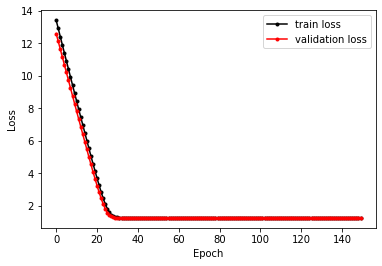

Final train loss: 1.2587566375732422
Final score:  0.6863820552825928
Final weights: [array([[-0.19659801],
       [-0.08294599],
       [-0.23220327],
       [-0.23497966],
       [-0.53534436],
       [ 0.0153313 ],
       [-0.02137978],
       [ 0.02137978],
       [-0.01877693],
       [ 0.01877693],
       [ 0.9293181 ],
       [ 1.4734573 ]], dtype=float32), array([13.356122], dtype=float32)]
Final validation loss: 1.2574702501296997
----------Test set performance ---------
Model accuracy on test set: 0.69
The root mean squared error (RMSE) on test set: 1.24


In [1036]:
#linear regression with gradient descent with learning rate = 0.1
model = build_model(num_features=len(X_train.columns), learning_rate=.1)

history = model.fit(
  x = X_train,
  y = y_train,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=150,
  batch_size=200,
  verbose=0)

plot_loss(model, history)

# calculate model prediction rmse for test data 
test_rmse = model.evaluate(X_test,
                             y_yt_test,
                             verbose=0)
print('----------Test set performance ---------')
print("Model accuracy on test set: {:.2f}".format(test_rmse[1]))
print("The root mean squared error (RMSE) on test set: {:.2f}".format(test_rmse[0]))




### Model: Gradient Boosted Decision Trees


In [1037]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

boosted_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, random_state=42)
boosted_model.fit(X_train, y_train)

# Print Coefficient of determination R^2
print("Model Accuracy: %.2f" % boosted_model.score(X_test, y_test))

# Create the mean squared error
rmse = np.sqrt(mean_squared_error(y_yt_test, boosted_model.predict(X_test)))
print("The root mean squared error (RMSE) on test set: {:.2f}".format(rmse))


Model Accuracy: 0.70
The root mean squared error (RMSE) on test set: 1.24


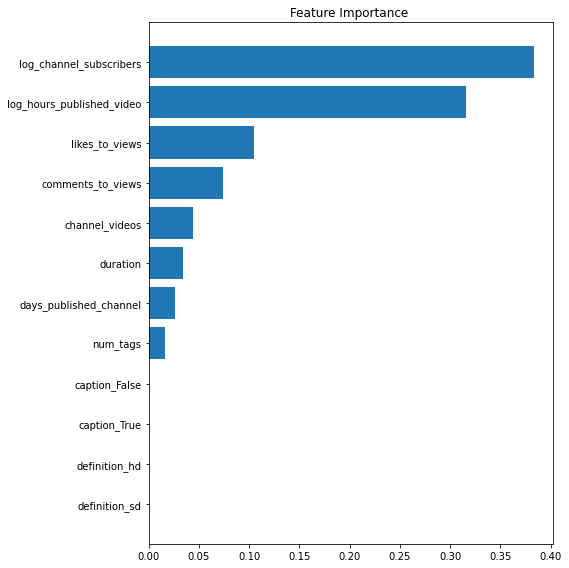

In [1038]:
from sklearn.inspection import permutation_importance
#
# Get Feature importance data using feature_importances_ attribute
#
feature_importance = boosted_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(X_train.columns))[sorted_idx])
plt.title('Feature Importance ')
result = permutation_importance(boosted_model, X_test, y_yt_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
plt.show()

### Model: Random Forest
This model was optimized using TPOT, an AutoML library.

In [1039]:
from sklearn.ensemble import RandomForestRegressor

# Average CV score on the training set was: -1.3537844790161722
tpot_model_1 = RandomForestRegressor(
    bootstrap=False,
    max_features=0.65,
    min_samples_leaf=1,
    min_samples_split=15,
    n_estimators=100
)

tpot_model_1.fit(X_train, y_train)

# Print Coefficient of determination R^2
print(f"Model Accuracy: {tpot_model_1.score(X_test, y_test):.2f}")

# Create the mean squared error
rmse_tpot_model_1 = np.sqrt(mean_squared_error(y_test, tpot_model_1.predict(X_test)))
print(f"The root mean squared error (RMSE) on test set: {rmse_tpot_model_1:.2f}")

Model Accuracy: 0.74
The root mean squared error (RMSE) on test set: 1.15


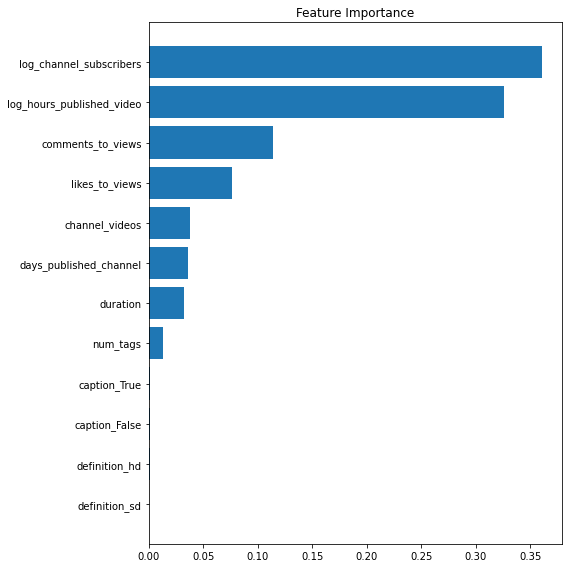

In [1040]:
# Get Feature importance data using feature_importances_ attribute
feature_importance = tpot_model_1.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(list(X_train.columns))[sorted_idx])
plt.title('Feature Importance')
fig.tight_layout()
plt.show()

### Table of performance with image pixel # pca components

| Thumbnail # of pca components | Model | rmse - test|
| ----- | ----- | ----- | 
| 0 | linear regression | 1.22 |
| 0 | boosted decision trees | 1.17 |
| 1 | linear regression | 1.22 |
| 1 | boosted decision trees | 1.21 |
| 3 | linear regression | 1.23 |
| 3 | boosted decision trees | 1.20 |
| 100 | linear regression | 1.35 |
| 100 | boosted decision trees | 1.17 |
| 274 | linear regression | 1.42 |
| 274 | boosted decision trees | 1.14 |


### Table of performance with image classification labels

| Image-label-one-hot | Model | rmse  -test |
| ----- | ----- | ----- | 
| N | linear regression | 1.22 |
| N | boosted decision trees | 1.17 |
| Y | linear regression | 1.54 |
| Y | boosted decision trees | 1.18 |


### Model: Neural Net

In [1043]:
#exclude object types or datetime types. 
#yt_data = yt_data.select_dtypes(exclude=["object",'datetime64[ns, UTC]'])

# 1,274 rows total -- approx 80/20 split
train = yt_data[:1000]
test = yt_data[1000:]

X_train = train.drop(['log_views'], axis=1)
y_train = train['log_views']
X_test = test.drop(['log_views'], axis=1)
y_test = test['log_views']

X_columns = X_train.columns

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (1000, 32897)
Test Shape: (189, 32897)


In [1042]:
def preprocess_data(IMAGE_PATH):
    """ Generate lists of images and video ids
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images  (np.ndarray): Images of shape (N, 120, 90, 3)
    """
    images = []
    video_ids = []

    # create lists of images `images_mini` 
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        
        # read video ID from path
        video_id = img.split('/')[0]
        video_id = video_id.split('.')[0]
        
        # read image
        img = load_img(
            IMAGE_PATH + img
        )
        
        # transform image to array
        img = img_to_array(img)

        #pre process
        img = img / 255
        
        # append to images
        images.append(img)
        video_ids.append(video_id)

    # stack images and trasnform to array
    images = np.stack(images)
    
    return images, video_ids

In [1044]:
images = preprocess_data(IMAGE_PATH)

In [1045]:
images[0].shape

(1189, 90, 120, 3)

In [1046]:
train_tuple = ([], []) # tuple for train set
test_tuple = ([], []) # tuple for test set

for i in range(len(images[1])):
    if images[1][i] in X_yt_train['video_id'].to_list():
        train_tuple[0].append(images[0][i])
        train_tuple[1].append(images[1][i])
    else:
        test_tuple[0].append(images[0][i])
        test_tuple[1].append(images[1][i])

print("Train tuple:", len(train_tuple[0]))
print("Test tuple:", len(test_tuple[0]))

Train tuple: 1000
Test tuple: 189


In [1047]:

# Create a dictionary that maps each video ID to its desired index in the sorted DataFrame
index_dict = {train_tuple[1][i]: i for i in range(len(train_tuple[1]))}

# Add a new column to X_train that contains the desired index for each video ID
X_train['index'] = X_train['video_id'].map(index_dict)

# Sort X_train by the 'index' column and drop the temporary column
X_train = X_train.sort_values('index').drop('index', axis=1)

In [1049]:

# Create a dictionary that maps each video ID to its desired index in the sorted DataFrame
index_dict = {test_tuple[1][i]: i for i in range(len(test_tuple[1]))}

# Add a new column to X_train that contains the desired index for each video ID
X_test['index'] = X_test['video_id'].map(index_dict)

# Sort X_train by the 'index' column and drop the temporary column
X_test = X_test.sort_values('index').drop('index', axis=1)

In [1071]:
X_train = X_train.select_dtypes(exclude=["object",'datetime64[ns, UTC]'])
X_test = X_test.select_dtypes(exclude=["object",'datetime64[ns, UTC]'])
X_train = X_train.drop(columns = [col for col in X_train.columns if col.startswith('pixel')])
X_test = X_test.drop(columns = [col for col in X_test.columns if col.startswith('pixel')])
X_train = X_train.drop(columns = [col for col in X_train.columns if col.startswith('label')])
X_test = X_test.drop(columns = [col for col in X_test.columns if col.startswith('label')])



In [1073]:
def build_cnn_model(input_shape, num_stats_features,learning_rate):
    """
    Build a CNN model in Keras that takes in a 2D matrix of YouTube videos as samples and features, 
    including a pixel array and YouTube video stats such as hours published.

    Args:
        input_shape: A tuple representing the shape of the input matrix (height, width, channels).
        num_stats_features: An integer representing the number of YouTube video stats features.

    Returns:
        model: A Keras model object.
    """
    tf.random.set_seed(0)

    # Define the input layers for the pixel array and YouTube video stats features.
    pixel_input = Input(shape=input_shape, name='pixel_input')
    stats_input = Input(shape=(num_stats_features), name='stats_input')

    # Define the convolutional layers for the pixel array.
    conv1 = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(pixel_input)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    flatten1 = Flatten()(pool2)

    # Concatenate the flattened pixel array and the YouTube video stats features.
    concat = concatenate([flatten1, stats_input])

    # Define the output layers for the model.
    dense1 = Dense(units=64, activation='relu')(concat)
    dense2 = Dense(units=1, activation='linear')(dense1)

    # Build the model.
    model = tf.keras.models.Model(inputs=[pixel_input, stats_input], outputs=dense2)

    # We need to choose an optimizer. We'll use Adam.
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with mean squared error loss and mean absolute error metric.
    model.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics=[det_coeff])

    return model

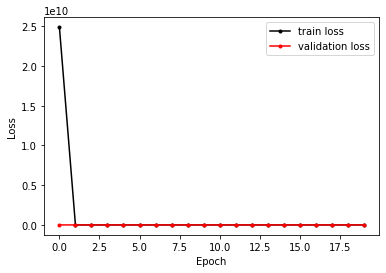

Final train loss: 2.2703230381011963
Final score:  -0.019959378987550735
Final weights: []
Final validation loss: 2.35935640335083
----------Test set performance ---------
Model accuracy on test set: -0.02
The root mean squared error (RMSE) on test set: 2.26


In [1079]:
model = build_cnn_model(input_shape=np.array(train_tuple[0]).shape[1:4],num_stats_features=len(X_train.columns), learning_rate=.1)

history = model.fit(
  x = [np.array(train_tuple[0]),np.array(X_train)],
  y = y_yt_train,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=20,
  batch_size=200,
  verbose=0)

plot_loss(model, history)

# calculate model prediction rmse for test data 
test_rmse = model.evaluate([np.array(test_tuple[0]),np.array(X_test)],
                             y_yt_test,
                             verbose=0)
print('----------Test set performance ---------')
print("Model accuracy on test set: {:.2f}".format(test_rmse[1]))
print("The root mean squared error (RMSE) on test set: {:.2f}".format(test_rmse[0]))


